# Topics in Applied Optimization (IIIT, Hyderabad, India)
# Jupyter Notebook Assignment-3 
### Instructor: Dr. Pawan Kumar (IIIT, H) (https://faculty.iiit.ac.in/~pawan.kumar/)
If you are not familiar with Jupyter notebook, before proceeding further, please go and watch this video:

https://www.youtube.com/watch?v=HW29067qVWk

### Name:Sudarshan S Harithas 
### Roll Number: 2021701008 


## Regarding assignments
### Deadline: 13 October 2019 (or 20 Oct with 15% penalty)
- all the assignment is to be done in this notbook itself
- any proof etc can be done on paper, and image is to be inserted in this notebook
- save this notebook with your roll number and upload it in moodle
- basic familiarity with python is required, brush up if necessary
- you are not allowed to use any existing library for gradient methods; this defeats the purpose of this assignment
- sample output is in the zip file of assignment
- if there are any doubt, then raise it in course moodle site, it may help others
- if you find typo, raise this issue in moodle promptly!
- please avoid copying from others, there may be oral exam to test your knowledge

# Implementation of Recommender System Using Latent Factor Model in Python

Please refer to the class slides for more detail. Also, for full detail, please refer the following main reference:

**[1] Y. Koren, R. Bell, and C. Volinsky, Matrix Factorization Techniques for Recommender Systems, Computer Archive, Volume 42, Issue 8, 2009** 

We first load the necessary libraries: 
1. matplotlib: needed for plotting figures and 
2. numpy needed for doing math

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# Now we write the main functions

We write everything inside a class LF, which stands for latent factor. We need the following functions:
1. main
2. train
3. mse
4. sgd
5. predict
6. full_matrix

# Short Tutorial on Recommender Systems
Please see lecture slides for more detail.

## Latent Factor Model
In a recommender systems, we are given an incomplete ratings matrix say R. The $(i,j)$ entry of this matrix is denoted by $r_{ij}.$ 
- We believe that there are dependencies in the matrix, i.e., the matrix is low rank, hence it can be written as a product of low rank matrices. 
- Even if the matrix is not strictly low rank, we believe that certain features are more important than others. In other words, if the ratings matrix were full, then after doing SVD, we get 
$$R = U S V^T$$
some of the singular values were very small, hence the matrix can be approximated well with truncated SVD. Let us consider the first $k$ largest singular vectors, then the truncated SVD is 
$$R \approx U_k S_k V_k.$$
- See IPSC notes for more detail on how to compute SVD or truncated SVD
- For a recomendation problem, for example, movie recomendation or news recommendation or product recommendation, etc, we believe that certain latent features are most important and play a major role in ratings.
- For movie recommendation, for example, latent factors could be comedy, adventure, horror, etc. These features are called latent, because the given data, which is ratings matrix does not explicitely tells about these.
- For recommendation systems, we cannot do SVD, because the matrix $R$ is incomplete! Obviously, we cant treat the missing entries to be zero! Hence, instead of doing SVD, we will consider an error function that consider only the ratings that are given. Let us assume that the ratings matrix can be modelled as a latent factors, i.e., suppose that $$R = PQ, \quad P \in \mathbb{R}^{n \times k}, Q \in \mathbb{R}^{k \times n},$$ then the given rating $$r_{ij} = p_{i*}q_{*j},$$ where $p_{i*}$ denotes the $i$th row of $P,$ and $q_{*j}$ denotes the $j$th column of $Q.$


## Optimization Model
- As mentioned above, we cannot directly do SVD, however, we can indeed create a **loss function** as follows:
$$\mathcal{L}(p_{1*}, p_{2*}, \dots p_{n*}, q_{*1}, q_{*2}, \dots, q_{*n}) = \sum_{(i,j) \in K} (r_{ij} - p_{i*}q_{*j}).$$
- Note above that we see loss function as a function the variables $p_{1*}, p_{2*}, \dots, p_{*n},$ which are row vectors of $P,$ and as the column vectors of $Q,$ which are $q_{*1}, q_{*2}, \dots, q_{*n}.$ This allows us to **vectorize**. Why vectorize?
- In machine learning the weights and their combinations with the given data creates a model. In this case, the model is $PQ.$ Since the $k,$ is a hyperparameter, it is likely that one may choose $P$ and $Q$ to have too many columns, i.e., too many weights are used, this will lead to a large model, and hence leading to **overfitting**. 
If you are not familiar with overfitting, then pause here, and see the video here:

https://www.youtube.com/watch?v=u73PU6Qwl1I

    - What did you learn from video? 
    - What is termed as model? 
    - What is the meaning of model being large? 
    - What is the difference between linear and logistic regression? 
    - What is underfitting? 
    - What is a bias? 
    - How do you characterize bias and variance using terms overfitting or underfitting?

- A well known way to avoid overfitting is to do regularizations, by penalizing **large model** size. Let us modify our loss function as follows:
$$\mathcal{L}(\cdot) = \sum_{(i,j) \in K} (r_{ij} - p_{i*}q_{*j})^2 + \gamma/2 (\| P \|_F^2 + \| Q \|_F^2)$$
    - We have added the term $\gamma/2(\| P \|_F^2 + \| Q \|_F^2).$ It is called **regularization term**
    - The parameter $\gamma$ is called the **regularization parameter**
    - High $\gamma$ would mean that we don't want big model size; this may help prevent overfitting
- Let $e_{ij}$ denote the error corresponding to each $(ij)$ term, 
$$e_{ij} = r_{ij} - \sum_{s=1}^k p_{is}q_{sj}$$
then let us define the new error term $\tilde{e}$
$$\tilde{e}_{ij} = e_{ij}^2 + \gamma/2 (\|P\|_F^2 + \| Q \|_F^2),$$ 
that is,
$$\tilde{e}_{ij} = (r_{ij} - \sum_{s=1}^k p_{is}q_{sj} )^2 + \gamma/2 (\|P\|_F^2 + \| Q \|_F^2)$$
- Note that $$\mathcal{L}(\cdot) = \sum_{(i,j) \in \mathcal{K}} \tilde{e}_{ij},$$
where $\mathcal{K}$ is the set of all indices for which ratings $r_{ij}$ are available.


## Gradient Method Versus Stochastic Gradient Methods
Following notes are taken from 
https://en.wikipedia.org/wiki/Stochastic_gradient_descent

For large dataset, $k$ and $n$ tend to be large, and computing gradient fully becomes too demanding. In machine learning or statistical estimation, we are usually required to find minimum of the loss functions of the form 
$$Q(w) = 1/n \sum_{j=1}^n Q_j (w)$$
That is loss function as "additive" decomposition. In other words, the loss function is a sum of the loss function where the sum is over the data samples. If $n$ is large, then computing full gradient is computationally demanding. However, if we indeed decide to run the gradient method. Then we recall the following steps:
1. Take initial random weight (possibly random and normally distributed between 0 and 1): $w^0$
2. $w^{i+1} = w^i - \alpha \nabla Q(w^i), \quad i=0, \dots$

Here the gradient $\nabla Q$ is the full gradient in the sense that
\begin{align}
\nabla Q(w) = \sum_{i=1}^n \nabla_{w}Q_i(w). \label{grad} \tag{1}
\end{align}

Here
\begin{align}
\nabla_w Q_i (w) = \begin{bmatrix}
\dfrac{\partial Q_i (w)}{\partial w_1} \\
\dfrac{\partial Q_i (w)}{\partial w_1} \\
\vdots \\
\dfrac{\partial Q_i (w)}{\partial w_n} \\
\end{bmatrix}  \label{grad2} \tag{2}
\end{align}

### Stochastic gradient  descent method
Stochastic gradient merthod, in short, SGD is a method (not necessarily descent due to stochasticity, but in expectation is usually is a descent), where the gradient is computed partially. For example, instead of summing for all $i=1...n,$ we can take a random sample, say $j_1,$ and do the update only for this sample as follows:
$$\nabla Q(w) = \nabla_{w}Q_{j_1}(w),$$
that is we have picked just one of the term i.e., $j_1$th term from \eqref{grad}.
Then the SGD update is:
$$w^{i+1} = w^i - \alpha \nabla Q_{j_1}(w^i), \quad i=0, \dots$$
Note that we could have taken few more terms in the sum, and would have updated for a batch. This is called, batched stochastic gradient descent.
It sounds incorrect, isnt it? Why such method may converge? With some basic assumption on the loss function, we can prove some convergence in expectance. More on convergence theory in class!

$\color{red}{\text{Question-0:}}$ Compute the full gradient of the loss function for recommendation system

$\color{red}{\text{Answer:}}$ 

![title](tao0.jpg)




In the following, we derive a stochastic gradient for the loss function for recommender loss.

## Gradient Method for Optimization Problem
- We want to use gradient method to minimize the error. An update in gradient method is given as follows
$$w^{i+1} = w^i - \nabla \mathcal{L}(w^i)$$
- To use gradient method, we need to compute gradient. If we see $\mathcal{L}$ as a function of $p_{ik}'$s and $q_{ki}'$s, then 
$$\dfrac{\partial \mathcal{L}}{\partial p_{is}} = 2e_{is} \dfrac{\partial e_{is}}{\partial p_{is}} + \gamma p_{is} = -2e_{is} q_{sj} + \gamma p_{is}$$
Similarly,
$$\dfrac{\partial \mathcal{L}}{\partial q_{sj}} = 2e_{sj} \dfrac{\partial e_{sj}}{\partial q_{sj}}+\gamma q_{sj} = -2e_{sj}p_{js} + \gamma q_{sj},$$
- The gradient vector $\nabla \mathcal{L}$ is given by
$$\nabla \mathcal{L} = \left(\dfrac{\partial \mathcal{L}}{\partial p_{11}}, \dots, \dfrac{\partial \mathcal{L}}{\partial p_{nk}}, \dfrac{\partial \mathcal{L}}{\partial q_{11}}, \dots, \dfrac{\partial \mathcal{L}}{\partial p_{kn}} \right)$$
- The weights $p_{is}$ can be updated as
$$p_{is} = p_{is} + \alpha (2e_{ij} q_{sj} - \gamma p_{is}) $$
- The weights $p_{sj}$ can be updated as
$$q_{sj} = q_{sj} + \alpha (2e_{ij} p_{js} - \gamma q_{sj}) $$
- We can vectorize $s.$ Finally, the vectorized form of the update looks like:
$$(p_{i+1*}, q_{*j+1})^T = (p_{i*}, q_{*j})^T + \alpha ((2e_{ij} q_{*j} - \gamma p_{i*}), (2e_{ij} p_{j*} - \gamma q_{*j}))^T  $$
- The error at $(p_{i*}, q_{*j})^T$ nedded above can be computed by $$e_{ij} =  r_{ij} - \text{prediction at}~ (i,j) $$
Here prediction at $(i,j)$ can be computed by making a call to predict() function below.

$\color{red}{\text{Question-1:}}$ Why the error is computed this way?

$\color{red}{\text{Answer:}}$ The expected characteristic in an error function is that the function tends towards 0 as the prediction and observation match.  The above error function is designed with this property, for all the elements in the matrix where an observation is available $r_{ij}$ the prediction at that point if its closer to the observation it would lead to 0 else the error would be propotionally high to the difference. Furthermore, since both the observations and the predictions (obtained from the combination of latent features) are of same dimensions a square loss would be an effective cost function.  




$\color{red}{\text{Question-2:}}$ Are the updates for $p_{i*}$ and $q_{*j}$ stochastic? Justify.

$\color{red}{\text{Answer:}}$ Yes, Since the values of $p$ and $q$ are updated for every residual individually it is a stochastic update.  

# Adding Bias
It is often observed in practice that adding a bias term helps. Let us add the bias term $b$ to the prediction function. The bias term is computed as the mean of the ratings matrix. See the predict function below to see how bias is added.

$\color{red}{\text{Question-2b:}}$ Read the main reference paper and justify why bias is added. Note in this notebook we add global bias. Which other bias term was suggested in the paper?

$\color{red}{\text{Answer:}}$

The observed variation in the rating is due to the effects associated with the user or the item, this is independent of any interaction and is known as bias or an intercept. The bias variables account for the average behaviour of the user and the average behaviour of the item, this further allows the variables $p_{i*}, q_{*j}$ to be modelled for the interaction part. 

Other bias suggested by user is 

1. User bias: Bias that describes the average rating given by a user.
2. Item Bias : Bias that describes the average rating received by an item. 


In [2]:
class LF(): 
    
    def __init__(self, R, K, alpha, gamma, iterations, Bias=True , BiasAll3=False):
        """
        Parameters:
        - R (ndarray)   : user-item rating matrix
        - K (int)       : number of latent dimensions
        - alpha (float) : learning rate
        - gamma (float)  : regularization parameter
        """
        
        self.R = R
        self.num_users, self.num_items = R.shape
        self.K = K
        self.alpha = alpha
        self.gamma = gamma
        self.iterations = iterations
        self.Bias = Bias
        self.b3 = BiasAll3

        
    def train(self, verbose=True):
        # Initialize user and item latent feature matrice
        self.P = np.random.normal(scale=1./self.K, size=(self.num_users, self.K))
        self.Q = np.random.normal(scale=1./self.K, size=(self.num_items, self.K))
        
        # Compute the global bias
        # For Question-6, you may want to initialize additional bias terms here
        self.b = np.mean(self.R[np.where(self.R != 0)]) * self.Bias
        
        
        ### For Question 10 
        
        self.b_i = np.zeros(self.num_items)
        self.b_u = np.zeros(self.num_users)
        
        # Create a list of training samples
        self.samples = [
            (i, j, self.R[i, j])
            for i in range(self.num_users)
            for j in range(self.num_items)
            if self.R[i, j] > 0
        ]
        
        # Perform stochastic gradient descent for number of iterations
        training_process = []
        for i in range(self.iterations):
            np.random.shuffle(self.samples)
            self.sgd()
            mse = self.mse()
            training_process.append((i, mse))
            if (i+1) % 10 == 0:
                print("SGD Iteration: %d ; error = %.4f" % (i+1, mse))
        
        return training_process

    def mse(self):
        """
        MSE: Compute Mean Square Error
        """
        xs, ys = self.R.nonzero()
        predicted = self.full_matrix()
        error = 0
        for x, y in zip(xs, ys):
            error += pow(self.R[x, y] - predicted[x, y], 2)
        return np.sqrt(error)

    def sgd(self):
        """
        SGD: Stochastic Graident Descent
        """
        for i, j, r in self.samples:
            # Compute prediction and error
            prediction = self.predict( i, j )
            e = r - prediction
            
            if self.b3 ==1:
                self.b_u[i] += self.alpha * (e - self.gamma * self.b_u[i])
                self.b_i[j] += self.alpha * (e - self.gamma * self.b_i[j])            
            # Keep a copy of row of P. It will be needed for update
            P_i = self.P[i, :][:]
            
            
            # Update user and item latent feature matrices
            self.P[i, :] += self.alpha * (2*e*self.Q[j, :] - self.gamma*P_i)
            self.Q[j, :] += self.alpha * (2*e*P_i - self.gamma*self.Q[j, :])
            
    
    ## Question 3 
    def gd(self):
        """
        GD: Graident Descent
        Replace self.sample below to full batch for gradient descent
        Feel free to remove everything, and implement from scratch
        """
        
        prediction_result = self.full_matrix()
        e = self.R - prediction_result
        
        X1, X2 = self.R.nonzero()
        
        dP = np.zeros_like(self.P)
        dQ = np.zeros_like(self.Q)
        
        for i, j in zip(X1, X2):
            dP[i, :] += 2*e[i,j]*self.Q[j, :] - self.gamma*self.P[i, :]
            dQ[j, :] += 2*e[i,j]*self.P[i, :] - self.gamma*self.Q[j, :]
            
        # Update user and item latent feature matrices
        self.P += self.alpha * (delta_P / len(valid_indices[0]))
        self.Q += self.alpha * (delta_Q / len(valid_indices[0]))
        
        
            

    def predict(self, i, j):
        """
        Prediction: Predicted the rating of user i and item j
        """
        
        if self.b3 == True:
            prediction =  self.b + self.P[i, :].dot(self.Q[j, :].T) + self.b_u[i] + self.b_i[j]
        else: 
            prediction = self.b + self.P[i, :].dot(self.Q[j, :].T)

        return prediction
    
    def full_matrix(self):
        """
        The rating matrix using the biases P and Q
        """
        return self.b + self.P.dot(self.Q.T)


In [3]:
R = np.array([
    [5, 3, 0, 1],
    [4, 0, 0, 1],
    [1, 1, 0, 5],
    [1, 0, 0, 4],
    [0, 1, 5, 4],
])

lf = LF(R, K=2, alpha=0.1, gamma=0.01, iterations=100)
training_process = lf.train()
print()
print("P x Q:")
print(lf.full_matrix())
print()
print("Global bias:")
print(lf.b)
print()

SGD Iteration: 10 ; error = 0.2902
SGD Iteration: 20 ; error = 0.1433
SGD Iteration: 30 ; error = 0.0961
SGD Iteration: 40 ; error = 0.0563
SGD Iteration: 50 ; error = 0.0465
SGD Iteration: 60 ; error = 0.0347
SGD Iteration: 70 ; error = 0.0281
SGD Iteration: 80 ; error = 0.0305
SGD Iteration: 90 ; error = 0.0289
SGD Iteration: 100 ; error = 0.0274

P x Q:
[[4.99919772 3.00452861 2.80733284 1.01439992]
 [4.0102447  4.36613599 0.89251147 1.0088934 ]
 [1.00643457 1.01353802 4.77133154 4.99563262]
 [1.00575865 2.86839435 2.36981112 4.0044652 ]
 [2.37770791 1.0037078  4.99481564 3.99914666]]

Global bias:
2.769230769230769



#### Note* : Incase the above code results in a 'nan' output and the graph does not converge.  Restart and clear the output of the kernel and run the code again. It would lead to a result as expected. 

# More questions

$\color{red}{\text{Question-3:}}$ Implement the full gradient descent method

$\color{red}{\text{Answer:}}$ Complete gd function above

$\color{red}{\text{Question-4:}}$ Vectorize the updates of p and q, by vectorizing s (detailed above)

$\color{red}{\text{Answer:}}$ Fill the TODO in code above

### Using the code below, answer the following:

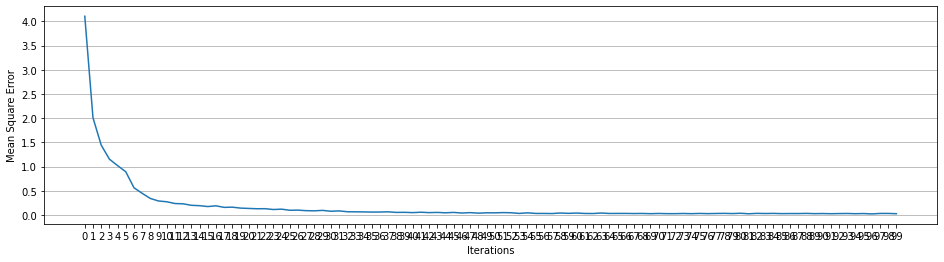

In [4]:
x = []
y =[]

for x1, y1 in training_process:
    x.append(x1)
    y.append(y1)



plt.figure(figsize=((16,4)))
plt.plot(x, y)
plt.xticks(x, x)
plt.xlabel("Iterations")
plt.ylabel("Mean Square Error")
plt.grid(axis="y")

$\color{red}{\text{Question-5:}}$ Plot the MSE versus iterations for $\alpha=1, \gamma=0.01$ and 100 iterations of SGD

$\color{red}{\text{Answer:}}$ set $\alpha= 0.02$ as $\alpha= 1$  would return $nan$

SGD Iteration: 10 ; error = 2.3874
SGD Iteration: 20 ; error = 1.1906
SGD Iteration: 30 ; error = 0.9261
SGD Iteration: 40 ; error = 0.8141
SGD Iteration: 50 ; error = 0.7598
SGD Iteration: 60 ; error = 0.7340
SGD Iteration: 70 ; error = 0.7213
SGD Iteration: 80 ; error = 0.7158
SGD Iteration: 90 ; error = 0.7125
SGD Iteration: 100 ; error = 0.7110


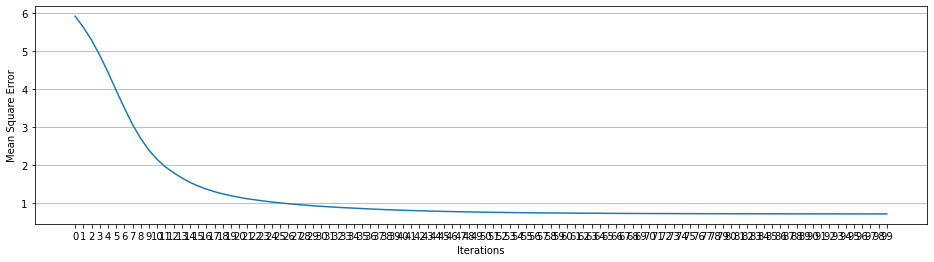

In [5]:
lf = LF(R, K=2, alpha=0.02, gamma=0.01, iterations=100)
training_process = lf.train()

x = []
y =[]

for x1, y1 in training_process:
    x.append(x1)
    y.append(y1)


plt.figure(figsize=((16,4)))
plt.plot(x, y)
plt.xticks(x, x)
plt.xlabel("Iterations")
plt.ylabel("Mean Square Error")
plt.grid(axis="y")

$\color{red}{\text{Question-6:}}$ Show the plot for 50 iterations, $\alpha=1, \gamma=0.01$ of SGD without bias, i.e., $b=0$

$\color{red}{\text{Answer:}}$ set $\alpha= 0.02$ as $\alpha= 1$  would return $nan$

SGD Iteration: 10 ; error = 5.8904
SGD Iteration: 20 ; error = 2.2376
SGD Iteration: 30 ; error = 0.6665
SGD Iteration: 40 ; error = 0.4716
SGD Iteration: 50 ; error = 0.3418


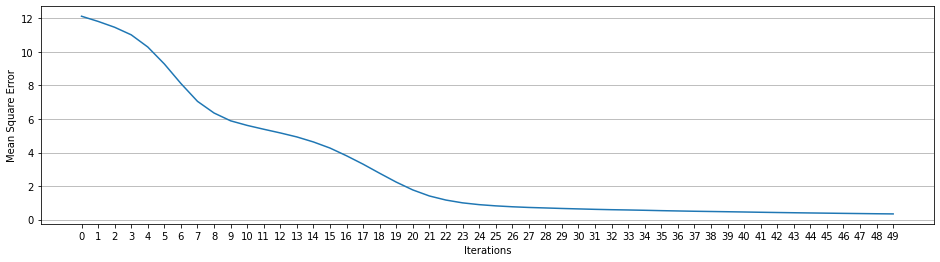

In [6]:
lf = LF(R, K=2, alpha=0.02, gamma=0.01, iterations=50, Bias=False)
training_process = lf.train()


x = []
y =[]

for x1, y1 in training_process:
    x.append(x1)
    y.append(y1)


plt.figure(figsize=((16,4)))
plt.plot(x, y)
plt.xticks(x, x)
plt.xlabel("Iterations")
plt.ylabel("Mean Square Error")
plt.grid(axis="y")

$\color{red}{\text{Question-7:}}$ Repeat above with bias

$\color{red}{\text{Answer:}}$ 




SGD Iteration: 10 ; error = 3.5205
SGD Iteration: 20 ; error = 0.9263
SGD Iteration: 30 ; error = 0.6298
SGD Iteration: 40 ; error = 0.5096
SGD Iteration: 50 ; error = 0.4319


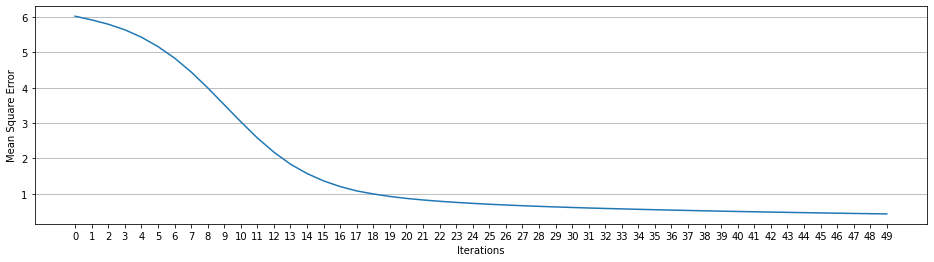

In [7]:
lf = LF(R, K=2, alpha=0.02, gamma=0.01, iterations=50, Bias=True)
training_process = lf.train()


x = []
y =[]

for x1, y1 in training_process:
    x.append(x1)
    y.append(y1)

plt.figure(figsize=((16,4)))
plt.plot(x, y)
plt.xticks(x, x)
plt.xlabel("Iterations")
plt.ylabel("Mean Square Error")
plt.grid(axis="y")

$\color{red}{\text{Question-8:}}$ Show plots with values of regularization parameters to be 1, 0.1, 0.01, 0.001 and for 50 iterations, and $\alpha=1, \gamma=0.01$

$\color{red}{\text{Answer:}}$ Paste all your plots here or below this cell.

SGD Iteration: 10 ; error = 3.3107
SGD Iteration: 20 ; error = 2.2458
SGD Iteration: 30 ; error = 2.1289
SGD Iteration: 40 ; error = 2.1905
SGD Iteration: 50 ; error = 2.1541
SGD Iteration: 10 ; error = 0.5745
SGD Iteration: 20 ; error = 0.4407
SGD Iteration: 30 ; error = 0.3815
SGD Iteration: 40 ; error = 0.3515
SGD Iteration: 50 ; error = 0.3184
SGD Iteration: 10 ; error = 1.3009
SGD Iteration: 20 ; error = 0.8186
SGD Iteration: 30 ; error = 0.6653
SGD Iteration: 40 ; error = 0.5767
SGD Iteration: 50 ; error = 0.4740
SGD Iteration: 10 ; error = 0.7413
SGD Iteration: 20 ; error = 0.6175
SGD Iteration: 30 ; error = 0.5198
SGD Iteration: 40 ; error = 0.3998
SGD Iteration: 50 ; error = 0.2788


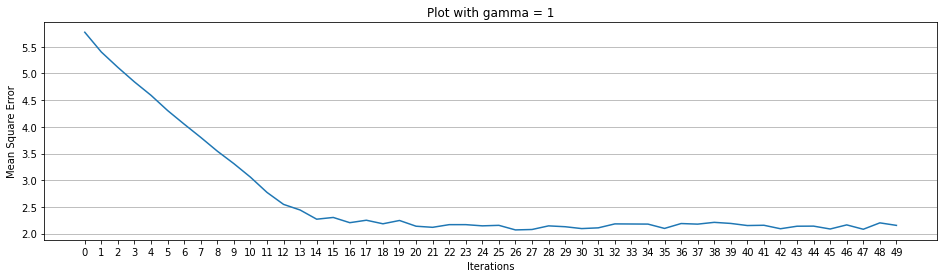

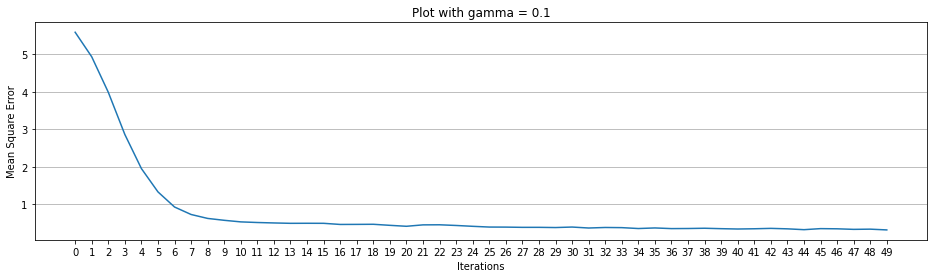

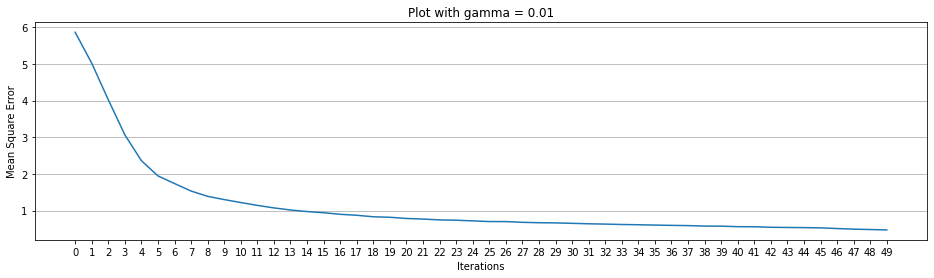

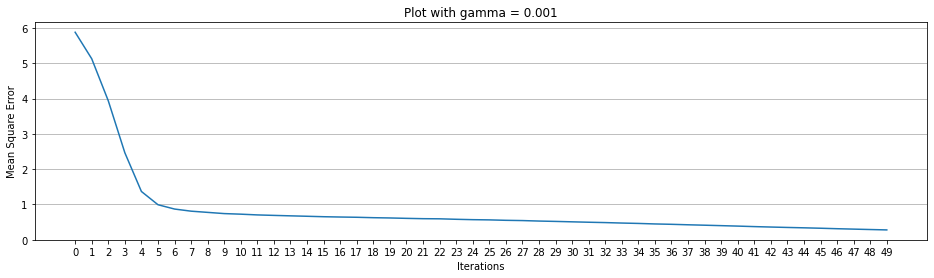

In [8]:
for idx, gamma in enumerate([1, 0.1, 0.01, 0.001]):
    
    lf = LF(R, K=2, alpha=0.05, gamma=gamma, iterations=50, Bias=True)
    training_process = lf.train(verbose=False)
    
    x = []
    y =[]
    
    for x1, y1 in training_process:
        x.append(x1)
        y.append(y1)
    
    
    plt.figure(figsize=((16,4)))
    plt.plot(x, y)
    plt.xticks(x, x)
    plt.xlabel("Iterations")
    plt.ylabel("Mean Square Error")
    plt.title( "Plot with " + "gamma = " +  str( gamma ))
    plt.grid(axis="y")
   



$\color{red}{\text{Question-9:}}$ Prove that the loss function is not convex. Is the loss function differentiable?

$\color{red}{\text{Answer:}}$ 


![title](tao1new_(1).jpg)
![title](tao1new_(2).jpg)
![title](tao1new_(3).jpg)
![title](tao1new_(4).jpg)



## Bonus Question

$\color{red}{\text{Question-10:}}$ In the reference paper [1] above, additional bias terms are recommended, implement it

$\color{red}{\text{Answer:}}$ Put your modified function here or below this cell.

SGD Iteration: 10 ; error = 2.7601
SGD Iteration: 20 ; error = 1.2355
SGD Iteration: 30 ; error = 1.1385
SGD Iteration: 40 ; error = 1.1183
SGD Iteration: 50 ; error = 1.1092


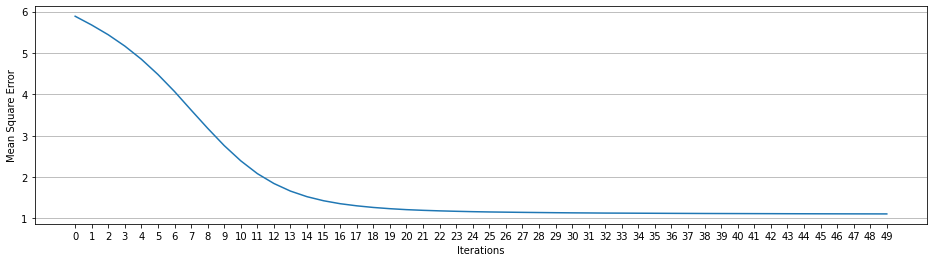

In [9]:
lf = LF(R, K=2, alpha=0.02, gamma=0.01, iterations=50, Bias=True ,BiasAll3=True )
training_process = lf.train()

x = []
y =[]

for x1, y1 in training_process:
    x.append(x1)
    y.append(y1)
    
plt.figure(figsize=((16,4)))
plt.plot(x, y)
plt.xticks(x, x)
plt.xlabel("Iterations")
plt.ylabel("Mean Square Error")
plt.grid(axis="y")

$\color{red}{\text{Question-11:}}$ Download the netflix ratings matrix, and run your algorithm.

$\color{red}{\text{Answer:}}$ Put your MSE versus iterations here.

## Thats All Folks! Further Readings or Infomation 
https://www.coursera.org/learn/networks-illustrated/lecture/8GPZT/netflix-timeline

# Keep Recommending!